# ValueMonitor - Create your own topic model

This page is a visualisation of the ValueMonitor prototype. In case you would like to use the notebook, click on the icon ‘**Run in Google Colab**’ hereunder:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tristandewildt/ValueMonitor/blob/main/ValueMonitor_create_own_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tristandewildt/ValueMonitor/blob/main/ValueMonitor_create_own_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Table of content:
* [1. Import dataset and packages](#import_dataset_and_packages)
* [2. Creating the topic model](#creating_the_topic_model)
* [3. Verifying the topic model](#verifying_the_topic_model)
* [4. Gap assessment](#gap_assessment)
* [5. Impact assessment](#impact_assessment)
* [6. Values in different societal_groups](#values_in_different_societal_groups)

## 1. Import dataset and packages  <a name="import_dataset_and_packages"></a>

In this step, the dataset and relavant python packages are imported

In [3]:
''' Packages'''

!pip install corextopic
!pip install joblib
!pip install tabulate
!pip install simple_colors
!pip install ipyfilechooser

import os, sys, importlib
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Button
import pickle
from ipyfilechooser import FileChooser
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
from google.colab import files
import nltk
import io
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


''' Source code'''

user = "tristandewildt"
repo = "ValueMonitor"
src_dir = "code"
pyfile_1 = "make_topic_model.py"
pyfile_2 = "create_visualisation.py"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}/{src_dir}"
if not path in sys.path:
    sys.path.insert(1, path)

make_topic_model = importlib.import_module(pyfile_1.rstrip(".py"))
create_visualisation = importlib.import_module(pyfile_2.rstrip(".py"))

from make_topic_model import *
from create_visualisation import *


'git' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
''' Dataset '''

csv = files.upload()
data = io.BytesIO(csv[list(csv.keys())[0]])
df = pd.read_csv(data)

In [ ]:
''' Cleaning of the dataset  '''

columns_to_select_as_text = ["text"]
column_as_date = ["date"]
other_columns_to_keep = []

wordtagging = True # True, False
tags_to_select = ['NN', 'NNP', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ']
# https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

pd.options.mode.chained_assignment = None  # default='warn'

df = clean_df(df, columns_to_select_as_text, column_as_date, other_columns_to_keep, wordtagging, tags_to_select)
df.info()

## 2. Creating the topic model <a name="creating_the_topic_model"></a>

In this step, we create a topic model in which some of the topics refer to values. The creation of topics that reflect values is done by means of so-called 'anchor' words. These words guide the algorithm in the creation of topics that reflect values.

Anchor words are typically words that people use to refer to (the idea of) a value, such as synonyms. After adding some anchor words and running the model, the algorithm will automatically pick up other words that refer to the value. This is because the algorithm has observed that these words are often mentionned in the same documents as the anchor words.

Finding the right anchor words is typically an iterative process, by observing the new topic model created by the algorithm. Some anchor words need to be added to ensure that some aspect of the value are not left behind (to be placed in *dict_anchor_words* in the cell below). Other words need to be removed since they do not refer to the value (in *list_rejected_words* in the cell below).

We have prefilled an number of anchor words for each value.

In [4]:
dict_anchor_words = {
"Justice and Fairness" : ["justice", "fairness", "fair", "equality", "unfair"],
"Privacy" : ["privacy", "personal data", "personal sphere", "data privacy", "privacy protection", "privacy concerns", 
             "confidentiality"],
"Cyber-security" : ["cyber", "security", "cybersecurity", "malicious", "attacks"],
"Environmnental Sustainability" : ["sustainability", "sustainable", "renewable", "durable", "durability",
                                  "sustainable development", "environmental"],
"Transparency" : ["transparency", "transparent", "transparently", "explainability", "interpretability", "explainable",
                 "opaque", "interpretable"],
"Accountability" : ["accountable", "accountability", "accountable", "traceability", "traceable"],
"Autonomy" : ["autonomy", "self-determination", "autonomy human", "personal autonomy"], 
"Democracy" : ["democracy", "democratic", "human rights", "freedom speech", "equal representation",
              "political"], 
"Reliability" : ["reliability", "reliable", "robustness", "robust", "predictability"],
"Trust" : ["trust", "trustworthy", "trustworthiness", "confidence", "honesty"],
"Well-being" : ["well being", "well-being", "wellbeing", "quality life",
               "good life", "qol", "life satisfaction", "welfare"],
"Inclusiveness" : ["inclusiveness", "inclusive", "inclusivity", "discrimination", "diversity"]
}

list_rejected_words = ["iop", "iop publishing", "publishing ltd", "publishing", "licence iop",
                       "mdpi basel", "basel switzerland", "mdpi", "basel", "licensee mdpi", "licensee", "authors licensee", 
                       "switzerland", "authors", "publishing limited", "emerald", "emerald publishing", ]

list_anchor_words_other_topics = [
        ["internet of things", "iot", "internet things", "iot devices", "things iot"],
        ["artificial intelligence", "ai", "artificial"],
]



In [5]:
number_of_topics_to_find = 20
number_of_documents_in_analysis = 2000

number_of_words_per_topic_to_show = 10
number_of_words_per_topic = 10

'''--------------------------------------------------------------------------''' 

model_and_vectorized_data = make_anchored_topic_model(df, number_of_topics_to_find, min(number_of_documents_in_analysis, len(df)), dict_anchor_words, list_anchor_words_other_topics, list_rejected_words)
topics = report_topics(model_and_vectorized_data[0], dict_anchor_words,number_of_words_per_topic)
df_with_topics = create_df_with_topics(df, model_and_vectorized_data[0], model_and_vectorized_data[1], number_of_topics_to_find)

Topic #0 (Justice and Fairness): sustainability, environmental, environmental sustainability, initiatives advance, advance economic, are keen, economic growth, sureshpprabhu are, growth environmental, initiatives
Topic #1 (Privacy): industry, biofuels industry, have
Topic #2 (Cyber-security): made, feed, used, production, corn, biofuel, poetbiofuels, ethanol
Topic #3 (Environmnental Sustainability): are aware, europe russia, russia is, is ready, oil ban, russia, help malaysia, is, nst_online, help
Topic #4 (Transparency): rt, biofuels co, biodiesel
Topic #5 (Accountability): solar, wind, power, energy, using
Topic #6 (Autonomy): rfs, demand, being, was, market
Topic #7 (Democracy): biomass, bioenergy, things, amp
Topic #8 (Reliability): emissions, way, be
Topic #9 (Trust): new, has, fuel, technology
Topic #10 (Well-being): use
Topic #11 (Inclusiveness): epa, hearing, e15, refinery, iagovernor, biofuels digest, digest, ethanolrfa, waiver, rin


## 3. Verifying the topic model   <a name="verifying_the_topic_model"></a>

To verify whether topics sufficiently refer to values, the code hereunder can be used to evaluate whether documents indeed address the value in question.

In [ ]:
def plot_print_sample_articles_topic(selected_value, size_sample, window):

    show_extracts = True # True, False
    show_full_text  = False # True, False

    print_sample_articles_topic(df_with_topics, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], size_sample =(5,50, 5), window = (1,100, 1))

## 4. Value Prioritization

The visualisation here can be used to evaluate the prioritization of values in the dataset.

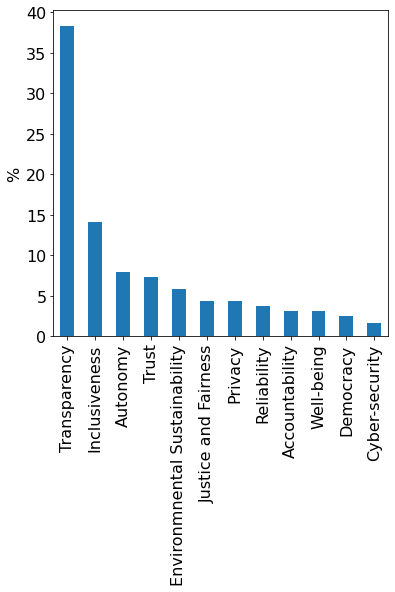

In [6]:
create_vis_frequency_values(df_with_topics, dict_anchor_words)

The code hereunder can be used to explore which articles have been assigned to the different values

In [ ]:
def plot_print_sample_articles_topic(selected_value, size_sample, window):

    show_extracts = True # True, False
    show_full_text  = False # True, False

    print_sample_articles_topic(df_with_topics, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], size_sample =(5,50, 5), window = (1,100, 1))

## 5. Values over time

The code hereunder can be used to study how the frequency of values has changed over time

In [ ]:
def plot_create_vis_values_over_time (resampling, smoothing, max_value_y):
    
    T0 = "1960-01-01" #YYYY-MM-DD
    T1 = "2023-01-01" #YYYY-MM-DD

    values_to_include_in_visualisation = []
    #values_to_include_in_visualisation = ['Privacy', 'Sustainability']
    
    resampling_dict = {"Year": "Y", "Month": "M", "Day": "D"}
    resampling = resampling_dict[resampling]
    #df_with_topics_short = df_with_topics.loc[(df_with_topics['date'] >= dateutil.parser.parse(T0)) & (df_with_topics['date'] <= dateutil.parser.parse(T1))]
    df_with_topics_short = df_with_topics.loc[(df_with_topics['date'] >= pd.Timestamp(dateutil.parser.parse(T0), tz='tzlocal()')) & (df_with_topics['date'] <= pd.Timestamp(dateutil.parser.parse(T1), tz='tzlocal()'))]

    create_vis_values_over_time(df_with_topics_short, dict_anchor_words, resampling, values_to_include_in_visualisation, smoothing, max_value_y)  
    
interact(plot_create_vis_values_over_time, smoothing = (0.25,3, 0.25), max_value_y = (5,100, 5), resampling = ["Year", "Month", "Day"])

The code hereunder can be used to explore which articles have been assigned to the different values and for specific timeframes.

In [ ]:
def plot_print_sample_articles_topic(selected_value, size_sample, window):

    T0 = "1960-01-01" #YYYY-MM-DD
    T1 = "2023-01-01" #YYYY-MM-DD
    
    show_extracts = True # True, False
    show_full_text  = False # True, False

    #df_with_topics_short = df_with_topics.loc[(df_with_topics['date'] >= dateutil.parser.parse(T0)) & (df_with_topics['date'] <= dateutil.parser.parse(T1))]
    df_with_topics_short = df_with_topics.loc[(df_with_topics['date'] >= pd.Timestamp(dateutil.parser.parse(T0), tz='tzlocal()')) & (df_with_topics['date'] <= pd.Timestamp(dateutil.parser.parse(T1), tz='tzlocal()'))]

    print_sample_articles_topic(df_with_topics_short, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], size_sample =(5,50, 5), window = (1,100, 1))